# Zero-Shot Classification with OpenAI

<u><b>Full Procedure<u><b>

1. Import Dependencies and Read Data
- Standard libraries for data handling, evaluation metrics, and the OpenAI API are imported
- An instance of the OpenAI client is created to enable API calls for classification
- The dataset is loaded from a CSV file. It includes the already vectorized text in the form of embeddings, that are converted from strings to Python lists using <code>literal_eval</code>

2. Define the Zero-Shot Classification Function
- A function is created to send text samples and candidate labels to the OpenAI API for zero-shot classification, leveraging the model’s ability to make inferences without prior training on the labels
- The function is applied to each example in the dataset, returning model predictions
- Classification performance is evaluated using metrics such as precision, recall, and F1-score. A precision-recall plot is generated to visualize performance

### Imports and Read Data

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from typing import List, Optional

from openai import OpenAI

from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay

client = OpenAI()

In [3]:
# Define embedding model and data path
EMBEDDING_MODEL = "text-embedding-3-small"

data_path = "bug_reports_mozilla_firefox_resolved_fixed_comments_embeddings.csv"

In [4]:
# The embeddings are already stored in the CSV, and need to be transformed from strings to lists
data = pd.read_csv(data_path)
data["Embeddings"] = data.Embeddings.apply(literal_eval).apply(np.array)

In [5]:
data.head(2)

,Bug ID,Type,Summary,Product,Component,Status,Resolution,Priority,Severity,Description,Concat,N_tokens,Embeddings
0,1955715,enhancement,Update addonsInfo asrouter targeting to allow ...,Firefox,Messaging System,RESOLVED,FIXED,P1,--,"Currently, the addonsInfo targeting returns an...",summary update addonsinfo asrouter target allo...,80,"[-0.015150155872106552, 0.003520532278344035, ..."
1,1953155,task,Enable expand on hover and remove coming soon ...,Firefox,Sidebar,RESOLVED,FIXED,P1,--,"When expand on hover is enabled, the message s...",summary enable expand on hover remove coming s...,55,"[-0.01597077213227749, 0.009659321047365665, 0..."


In [6]:
data["Priority"].value_counts()

Priority
P1    5534
P2    2999
P3     623
Name: count, dtype: int64

In [7]:
# Drop all P3 examples
data = data[data["Priority"] != "P3"].reset_index(drop = True)

In [8]:
# Mapping the 'label' column (Priority) to a more human-readable text
data["Priority"] = data.Priority.replace({'P1': "priority", 'P2': "non-priority"})

In [9]:
data["Priority"].value_counts()

Priority
priority        5534
non-priority    2999
Name: count, dtype: int64

### Zero-Shot Classification

In [10]:
# Function to transform the text into embeddings using the model available in the OpenAI API
def get_embedding(text: str, model = "text-embedding-3-small", **kwargs) -> List[float]:
    # Replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    response = client.embeddings.create(input = [text], model = model, **kwargs)

    return response.data[0].embedding

In [11]:
# Function to calculate the cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [14]:
# In the zero shot approach, we will embed the labels (Priority) and calculate the distance with the already vectorized text
# If the returned value is greater than zero, we classify the examples as being priority
# Otherwise, we classify the example as being non-priority
def evaluate_embeddings_approach(
    labels = ['non-priority', 'priority'],
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, model = model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = data["Embeddings"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'priority' if x > 0 else 'non-priority')

    report = classification_report(data.Priority, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(data.Priority, probas, pos_label = 'priority')
    _ = display.ax_.set_title("Precision - Recall Curve")

              precision    recall  f1-score   support

non-priority       0.34      0.61      0.44      2999
    priority       0.64      0.37      0.46      5534

    accuracy                           0.45      8533
   macro avg       0.49      0.49      0.45      8533
weighted avg       0.53      0.45      0.46      8533



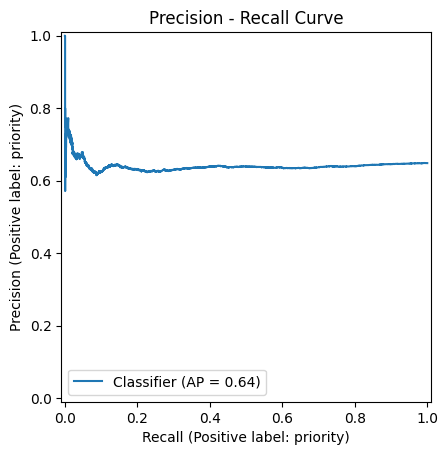

In [15]:
# This approach takes into consideration the labels as being words, and we calculate the similarity with the text
# Hence, it is called Zero-Shot, because we use the knowledge from the models in the OpenAI API
evaluate_embeddings_approach(labels = ['non-priority', 'priority'], model = EMBEDDING_MODEL)

              precision    recall  f1-score   support

non-priority       0.34      0.17      0.22      2999
    priority       0.65      0.82      0.72      5534

    accuracy                           0.59      8533
   macro avg       0.49      0.49      0.47      8533
weighted avg       0.54      0.59      0.55      8533



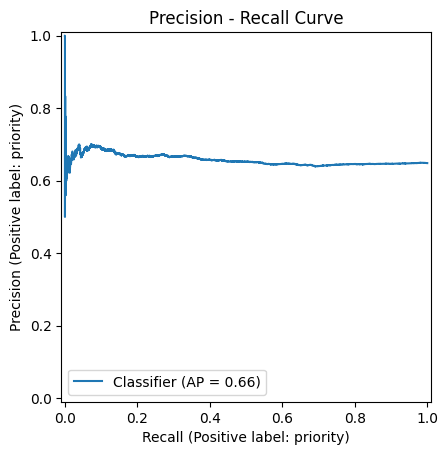

In [16]:
# We can specify the text to the labels even further, so we can get a more precise result
evaluate_embeddings_approach(labels = ['A Firefox bug report that is not a priority.', 'A Firefox bug report that is a priority.'])